In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
import omicverse as ov
from omicverse.utils import mde
import scanpy as sc
import scvelo as scv
ov.utils.ov_plot_set()

In [3]:
adata=scv.datasets.dentategyrus()
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [4]:
import numpy as np
import pandas as pd
bulk=pd.read_csv('data/GSE74985_mergedCount.txt.gz',index_col=0,sep='\t')
bulk=ov.bulk.Matrix_ID_mapping(bulk,'genesets/pair_GRCm39.tsv')
bulk.head()

,dg_d_1,dg_d_2,dg_d_3,dg_v_1,dg_v_2,dg_v_3,ca4_1,ca4_2,ca4_3,ca3_d_1,...,ca3_v_3,ca2_1,ca2_2,ca2_3,ca1_d_1,ca1_d_2,ca1_d_3,ca1_v_1,ca1_v_2,ca1_v_3
Olfr692,0,0,0,6,8,0,19,3,0,0,...,10,12,16,3,0,3,1,1,0,0
Olfr637-ps1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Olfr1272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm23613,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
Tap2,0,0,0,5,0,3,80,29,16,8,...,9,14,2,46,0,0,1,0,0,0


In [5]:
bulktb=ov.bulk2single.BulkTrajBlend(bulk_seq=bulk,single_seq=adata,
                                    celltype_key='clusters',)
#bulktb.bulk_preprocess_lazy(group=['dg_d_1','dg_d_2','dg_d_3'])
#bulktb.single_preprocess_lazy()

In [6]:
bulktb.vae_configure(cell_target_num=200)

......drop duplicates index in bulk data
......deseq2 normalize the bulk data
......log10 the bulk data
......calculate the mean of each group
......normalize the single data
normalizing counts per cell
    finished (0:00:00)
......log1p the single data
......prepare the input of bulk2single
...loading data


In [7]:
features=bulktb.vae_model.input_data['input_sc_data'].T
labels=bulktb.vae_model.input_data['input_sc_meta']['Cell_type'].astype('str')

# 将类别字符串映射为数字编码
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
labels_encoded = labels.map(label_mapping)

# 转换为 PyTorch 张量
features_tensor = torch.Tensor(features.values)
labels_tensor = torch.LongTensor(labels_encoded.values)  # 使用 LongTensor 存储整数标签


In [8]:
# 创建 DataLoader（如果需要）
# DataLoader 可以帮助你批量加载数据，方便训练
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [11]:
n_epochs=200
batch_size=64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
n_classes=len(list(set(labels)))  # 类别数量
img_size=32
channels=1
sample_interval=400
n_features=features.shape[1]

In [10]:
features.shape

(2930, 12953)

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes,n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, n_features),
            #nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        #img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + n_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img, self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [13]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [14]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [15]:
# ----------
#  Training
# ----------
from tqdm import trange,tqdm

n_epochs=5000

bar = tqdm(range(n_epochs))
#for epoch in trange(n_epochs):
d_loss_li=[]
g_loss_li=[]
for epoch in bar:
    for i, (imgs, labels) in enumerate(data_loader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))
        

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        break
        
        

        
    bar.set_description(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
        )
    d_loss_li.append(d_loss.item())
    g_loss_li.append(g_loss.item())

[Epoch 4999/5000] [Batch 0/46] [D loss: 0.064183] [G loss: 0.598119]: 100%|██████████| 5000/5000 [01:12<00:00, 68.73it/s]


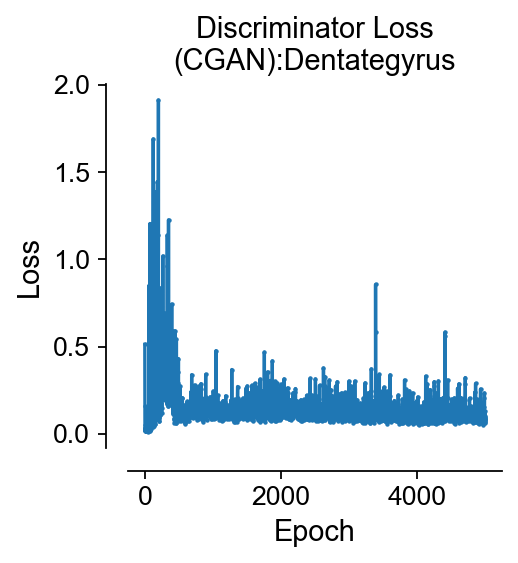

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(d_loss_li)),d_loss_li,s=1)
ax.plot(range(len(d_loss_li)),d_loss_li)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Discriminator Loss\n(CGAN):Dentategyrus',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_d_cgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_d_cgan_dg.pdf',dpi=300,bbox_inches='tight')


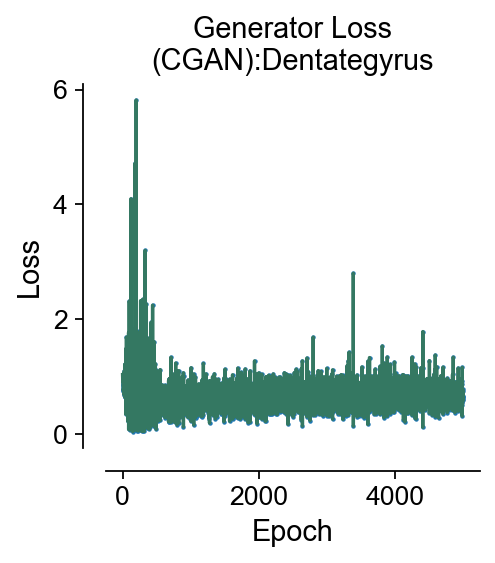

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(range(len(g_loss_li)),g_loss_li,s=1)
ax.plot(range(len(g_loss_li)),g_loss_li,color=ov.utils.blue_color[0])

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Generator Loss\n(CGAN):Dentategyrus',fontsize=13)
plt.xlabel('Epoch',fontsize=13)
plt.ylabel('Loss',fontsize=13)

plt.savefig('figures/loss_g_cgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/loss_g_cgan_dg.pdf',dpi=300,bbox_inches='tight')


In [18]:
Variable(FloatTensor(np.random.normal(0, 1, (100, latent_dim)))).shape

torch.Size([100, 100])

In [19]:
n_row=14
z = Variable(FloatTensor(np.random.normal(0, 1, (n_row * 100, latent_dim))))
# Get labels ranging from 0 to n_classes for n rows
labels = np.array([num for _ in range(100) for num in range(n_row)])
labels = Variable(LongTensor(labels))
gen_imgs = generator(z, labels)

In [20]:
gen_imgs.max()

tensor(9.9819, device='cuda:0', grad_fn=<MaxBackward1>)

In [21]:
gen_imgs.min()

tensor(-1.9895, device='cuda:0', grad_fn=<MinBackward1>)

In [22]:


import anndata
test_adata=anndata.AnnData(np.array(gen_imgs.cpu().detach().numpy()))
rev_dict=dict(zip(label_mapping.values(),label_mapping.keys()))
test_adata.obs['celltype_num']=labels.cpu().detach().numpy()
test_adata.obs['celltype']=test_adata.obs['celltype_num'].map(rev_dict)


In [23]:
test_adata.layers['scaled']=test_adata.X.copy()
ov.pp.pca(test_adata,layer='scaled',n_pcs=50)
test_adata

AnnData object with n_obs × n_vars = 1400 × 12953
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [24]:
test_adata.obsm["X_mde"] = ov.utils.mde(test_adata.obsm["scaled|original|X_pca"])
test_adata

AnnData object with n_obs × n_vars = 1400 × 12953
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [25]:
test_adata.var.index=features.columns

In [27]:
adata.uns['clusters_colors']

array(['#3ba458', '#404040', '#7a7a7a', '#fda762', '#6950a3', '#2575b7',
       '#08306b', '#e1bfb0', '#e5d8bd', '#79b5d9', '#f14432', '#fc8a6a',
       '#98d594', '#d0e1f2'], dtype=object)

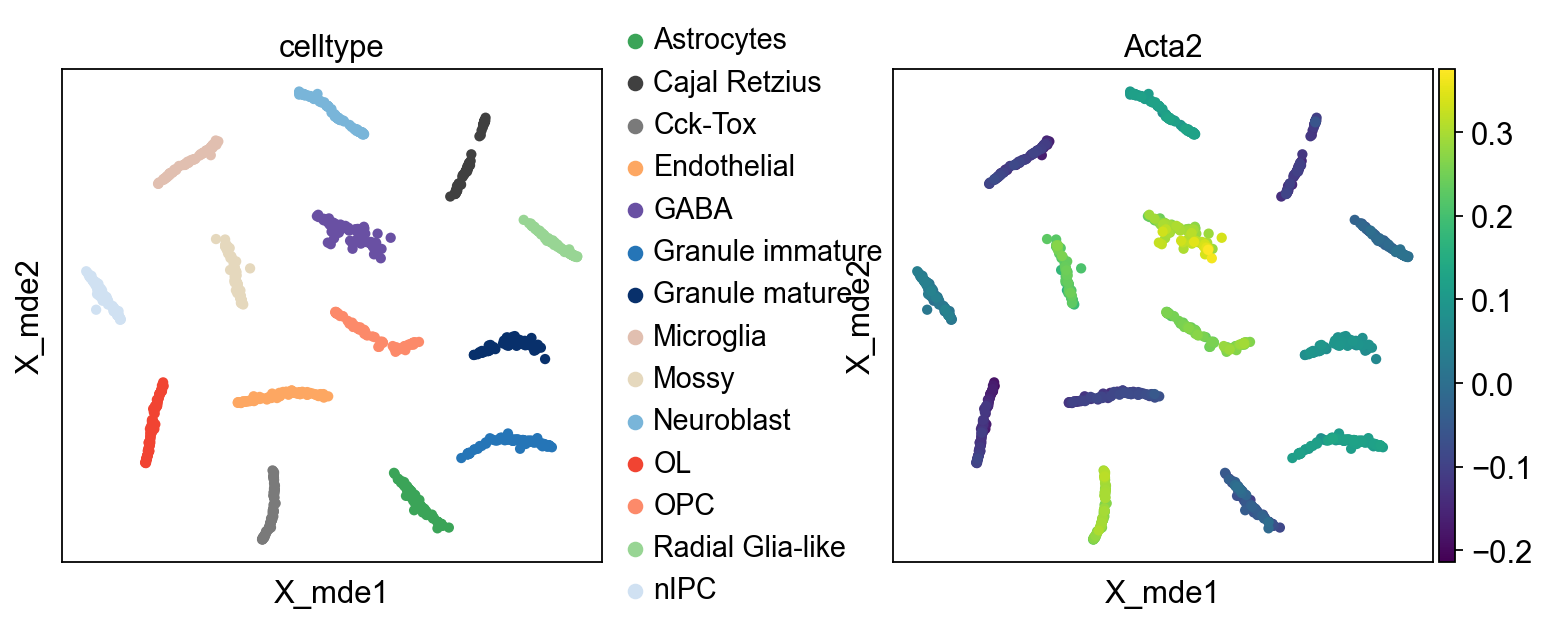

In [28]:
sc.pl.embedding(test_adata,
                basis='X_mde',
           color=['celltype','Acta2'],
           wspace=0.4,
            palette=adata.uns['clusters_colors'].tolist()
               )

In [29]:
adata.obs['celltype']=adata.obs['clusters'].copy()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


(<Figure size 480x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'Expression correlation'}, xlabel='scRNA-seq reference', ylabel='deconvoluted bulk-seq'>)

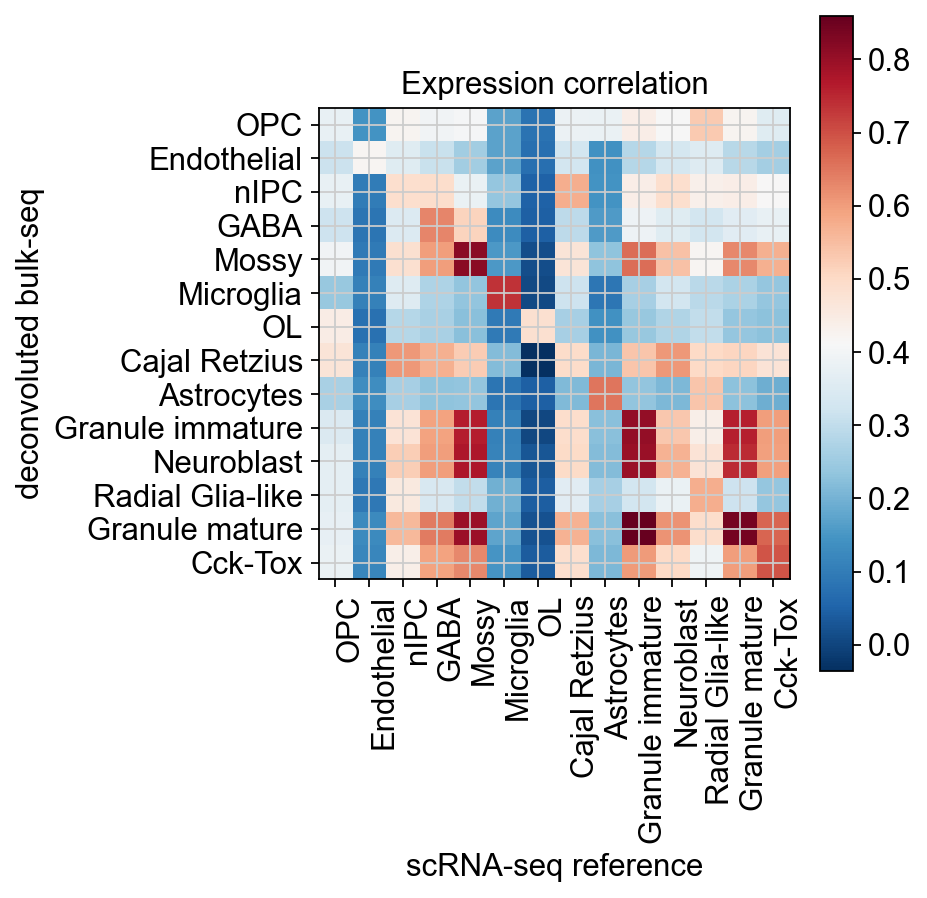

In [30]:
ov.bulk2single.bulk2single_plot_correlation(test_adata,adata,celltype_key='celltype')

In [32]:
#adata.uns['log1p']['base']=10

In [40]:
adata_t=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 13264/13913 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [41]:
cor_pd=ov.bulk2single.bulk2single_plot_correlation(adata_t,test_adata,celltype_key='celltype',
                                           return_table=True)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [42]:
#sc.tl.rank_genes_groups(single_data, celltype_key, method='wilcoxon')
marker_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(200)
#marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(generate_adata.var.index.tolist()))
marker = list(set(np.unique(np.ravel(np.array(marker_df))))&set(test_adata.var.index.tolist()))

# the mean expression of 200 marker genes of input sc data
sc_marker = adata[:,marker].to_df()
sc_marker['celltype'] = adata.obs['celltype']
sc_marker_mean = sc_marker.groupby('celltype')[marker].mean()

In [43]:
sc_marker_mean=sc_marker_mean.T

In [44]:
rf_ct = list(sc_marker_mean.columns)

In [45]:
cor_pd=pd.DataFrame(cor_pd,
                   index=rf_ct,
                   columns=rf_ct)

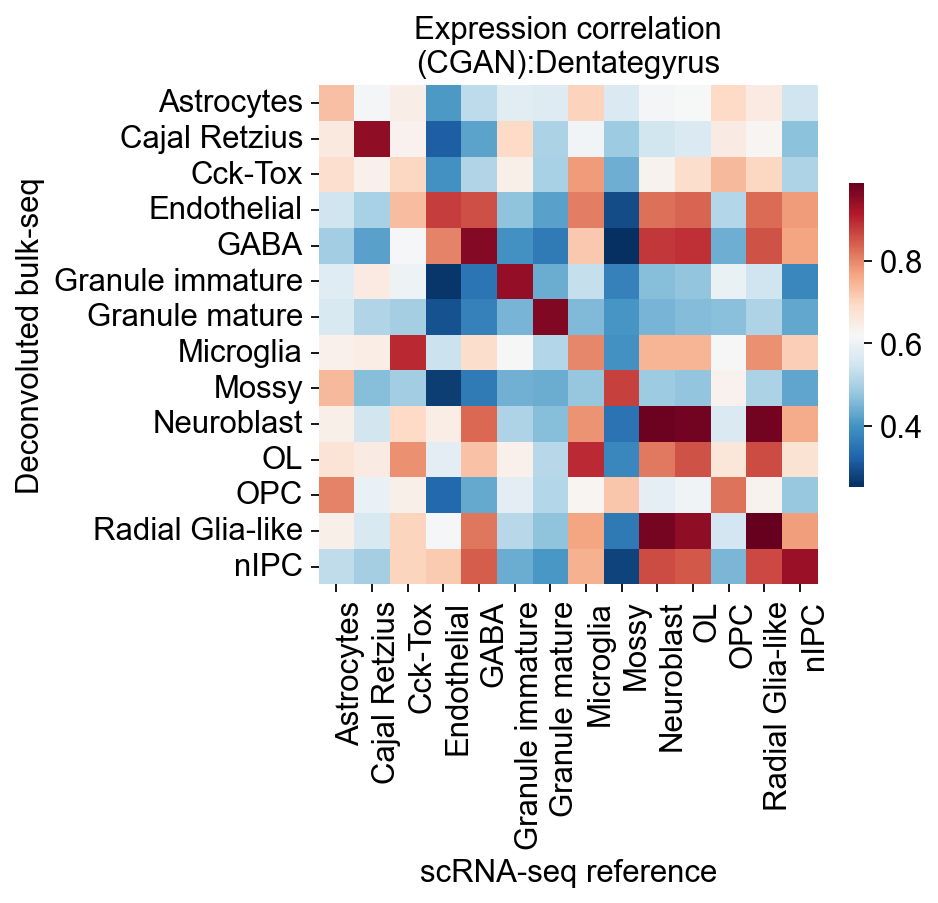

In [46]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cor_pd,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Expression correlation\n(CGAN):Dentategyrus")
plt.savefig('figures/heatmap_expcor_cgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_expcor_cgan_dg.pdf',dpi=300,bbox_inches='tight')


In [47]:
cmk1=ov.single.get_celltype_marker(test_adata,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [48]:
adata_hpc1=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=3000,
                      target_sum=1e4)

Begin robust gene identification
After filtration, 13264/13264 genes are kept. Among 13264 genes, 13189 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Hba-a1', 'Malat1', 'Ptgds', 'Hbb-bt']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson


In [49]:
cmk2=ov.single.get_celltype_marker(adata_hpc1,clustertype='celltype',
                                  scores_type='logfoldchanges')

...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [97]:
cmk1={}
for clt in test_adata.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(test_adata, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk1[clt]=degs['names'][:300].tolist()

In [98]:
cmk2={}
for clt in adata_hpc1.obs['celltype'].cat.categories:
    degs = sc.get.rank_genes_groups_df(adata_hpc1, group=clt, 
                                       key='rank_genes_groups', log2fc_min=2, 
                                       pval_cutoff=0.05)
    cmk2[clt]=degs['names'][:300].tolist()

In [99]:
all_gene=[]
for clt in cmk1.keys():
    all_gene+=cmk1[clt]
for clt in cmk2.keys():
    all_gene+=cmk2[clt]
all_gene=list(set(all_gene))

In [100]:
cmk1_pd=pd.DataFrame(index=all_gene)
for clt in cmk1.keys():
    cmk1_pd[clt]=0
    cmk1_pd.loc[cmk1[clt],clt]=1
cmk2_pd=pd.DataFrame(index=all_gene)
for clt in cmk2.keys():
    cmk2_pd[clt]=0
    cmk2_pd.loc[cmk2[clt],clt]=1

In [101]:
from scipy import spatial
plot_data=pd.DataFrame(index=test_adata.obs['celltype'].cat.categories,
                      columns=test_adata.obs['celltype'].cat.categories)
for clt1 in cmk1.keys():
    for clt2 in cmk1.keys():
    #print(clt,1 - spatial.distance.cosine(cmk1_pd['B'], cmk2_pd[clt]))
        plot_data.loc[clt1,clt2]=1 - spatial.distance.cosine(cmk1_pd[clt1], cmk2_pd[clt2])

In [102]:
plot_data=plot_data.astype(float)

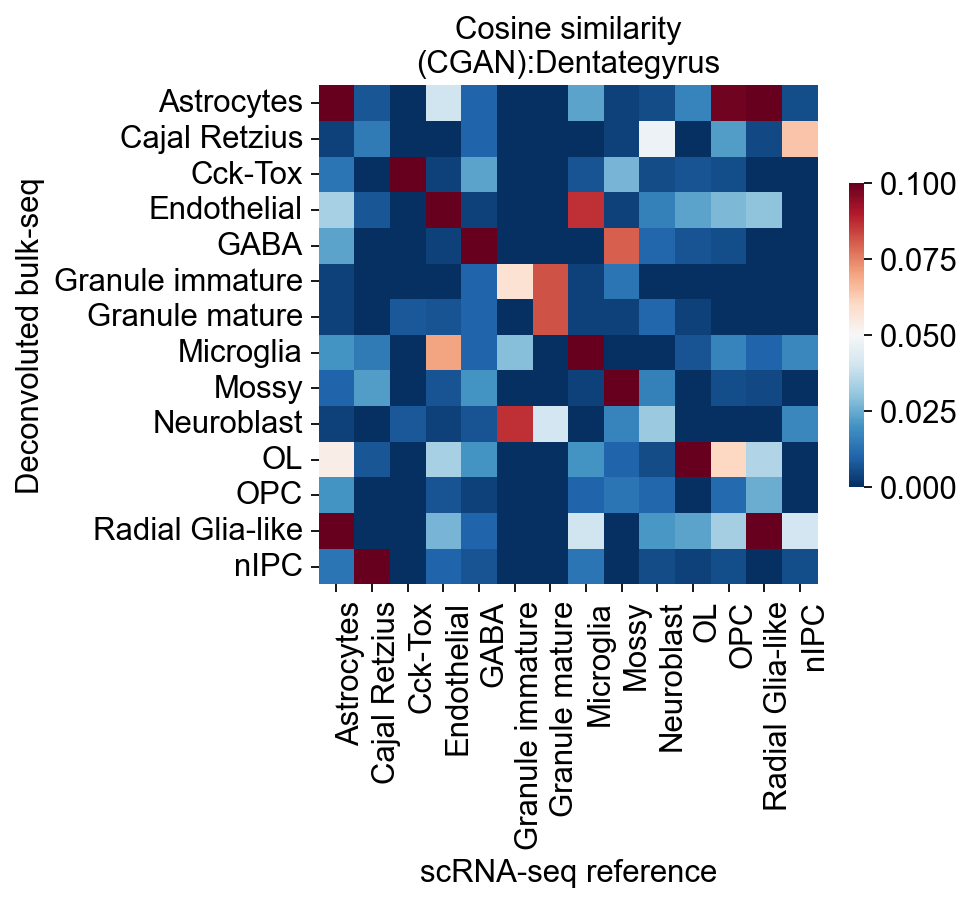

In [103]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(plot_data,cmap='RdBu_r',cbar_kws={'shrink':0.5},
           square=True,xticklabels=True,yticklabels=True,vmax=0.1)
plt.xlabel("scRNA-seq reference")
plt.ylabel("Deconvoluted bulk-seq")
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
#plt.colorbar(im)
ax.set_title("Cosine similarity\n(CGAN):Dentategyrus")
plt.savefig('figures/heatmap_cossim_cgan_dg.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/heatmap_cossim_cgan_dg.pdf',dpi=300,bbox_inches='tight')


In [58]:
adata3=test_adata[test_adata.obs['celltype']=='OPC']
adata3

View of AnnData object with n_obs × n_vars = 100 × 12953
    obs: 'celltype_num', 'celltype'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'celltype_colors', 'rank_genes_groups'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

In [64]:
bulktb.vae_model.single_data.obs['celltype']=bulktb.vae_model.single_data.obs['clusters']

In [67]:
import anndata
adata1=anndata.concat([bulktb.vae_model.single_data,adata3],
                     merge='same')
adata1

AnnData object with n_obs × n_vars = 3030 × 12953
    obs: 'celltype'

In [68]:
adata1.raw = adata1
sc.pp.highly_variable_genes(adata1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata1 = adata1[:, adata1.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [69]:
ov.pp.scale(adata1)
ov.pp.pca(adata1,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [70]:
adata1.obsm["X_mde"] = ov.utils.mde(adata1.obsm["scaled|original|X_pca"])
adata1

AnnData object with n_obs × n_vars = 3030 × 1802
    obs: 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'

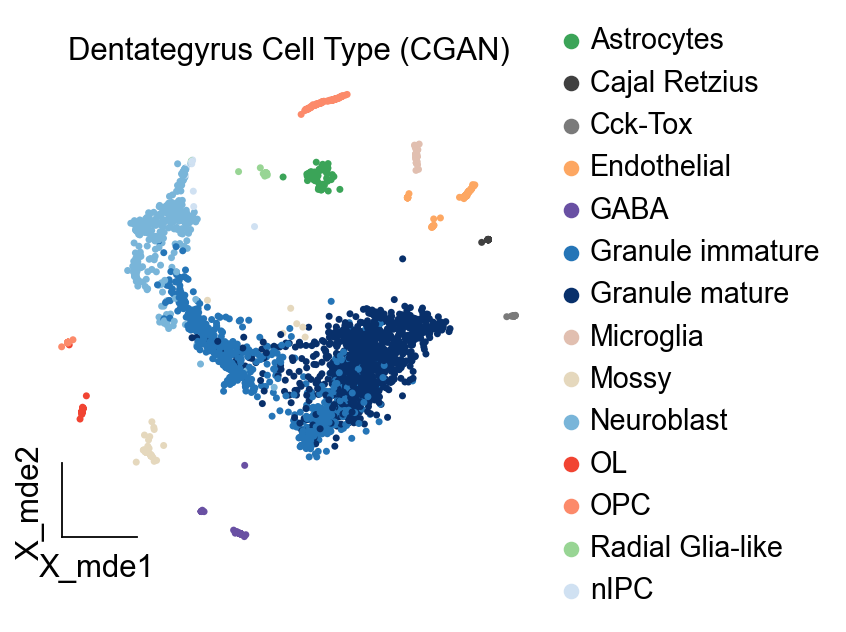

In [71]:
ov.utils.embedding(adata1,
                basis='X_mde',
           color=['celltype'],title='Dentategyrus Cell Type (CGAN)',
                   frameon='small',show=False,
           wspace=0.4,palette=adata.uns['clusters_colors'].tolist())
plt.savefig('figures/umap_dg_cgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/umap_dg_cgan.pdf',dpi=300,bbox_inches='tight')


In [72]:
adata2=bulktb.vae_model.single_data.copy()

In [73]:
adata2.raw = adata2
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata2 = adata2[:, adata2.var.highly_variable]

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [74]:
ov.pp.scale(adata2)
ov.pp.pca(adata2,layer='scaled',n_pcs=50)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [75]:
adata2.obsm["X_mde"] = ov.utils.mde(adata2.obsm["scaled|original|X_pca"])
adata2

AnnData object with n_obs × n_vars = 2930 × 2254
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'celltype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'log1p', 'hvg', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_umap', 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'ambiguous', 'spliced', 'unspliced', 'scaled', 'lognorm'

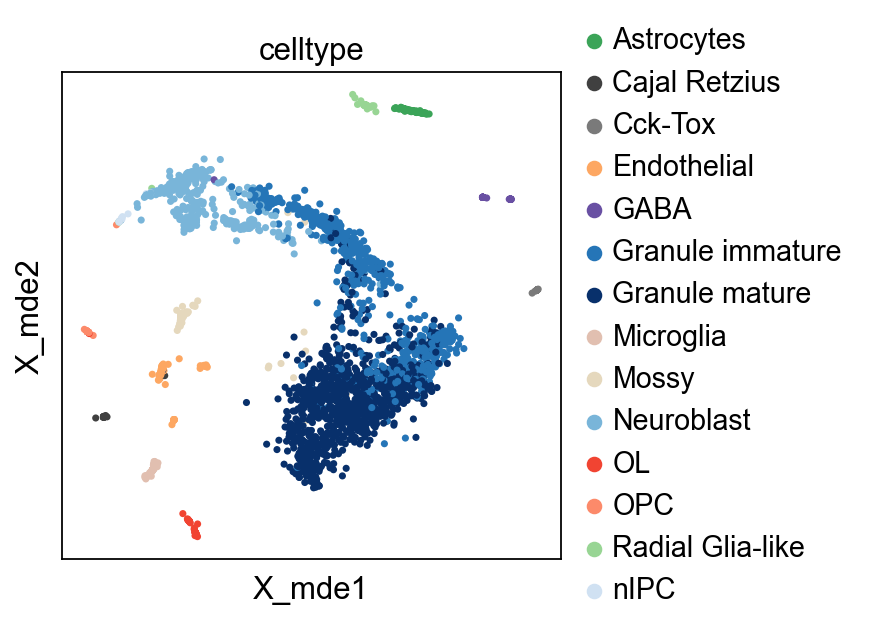

In [76]:
sc.pl.embedding(adata2,
                basis='X_mde',
           color=['celltype'],
           wspace=0.4,palette=adata.uns['clusters_colors'].tolist())

In [77]:
v0 = ov.single.pyVIA(adata=adata2,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['nIPC'],
                    dataset='group')
v0.run()

2023-10-05 14:34:43.856616	From root 26,  the Terminal state 36 is reached 5 times.
2023-10-05 14:34:45.015598	From root 26,  the Terminal state 37 is reached 184 times.
2023-10-05 14:34:45.941438	From root 26,  the Terminal state 38 is reached 346 times.
2023-10-05 14:34:47.343073	From root 26,  the Terminal state 39 is reached 45 times.
2023-10-05 14:34:48.557044	From root 26,  the Terminal state 41 is reached 155 times.
2023-10-05 14:34:49.734404	From root 26,  the Terminal state 45 is reached 177 times.
2023-10-05 14:34:51.109114	From root 26,  the Terminal state 46 is reached 45 times.
2023-10-05 14:34:52.566552	From root 26,  the Terminal state 50 is reached 11 times.
2023-10-05 14:34:53.956050	From root 26,  the Terminal state 51 is reached 49 times.
2023-10-05 14:34:53.986477	Terminal clusters corresponding to unique lineages are {8: 'Granule mature', 9: 'Microglia', 11: 'Astrocytes', 13: 'Endothelial', 15: 'Astrocytes', 16: 'Radial Glia-like', 28: 'Endothelial', 29: 'Endotheli

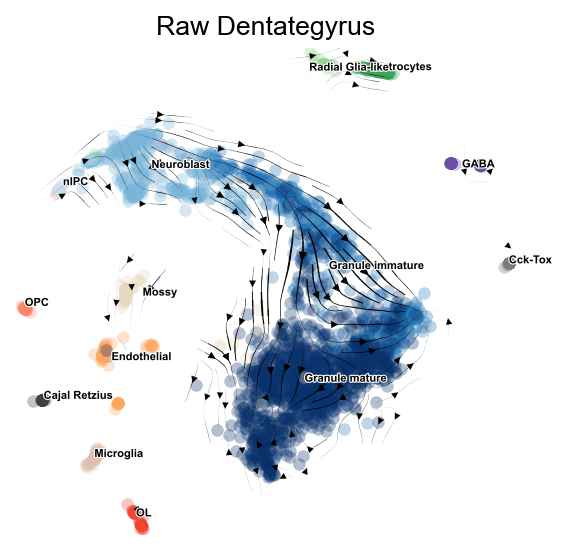

In [83]:
import matplotlib.pyplot as plt
fig,ax=v0.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Raw Dentategyrus',fontsize=12)
plt.savefig('figures/via_dg_raw.png',dpi=300,bbox_inches='tight')

In [79]:
v0.get_pseudotime(adata2)
sc.pp.neighbors(adata2,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata2,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [80]:
raw_transitions=pd.DataFrame(adata2.uns['paga']['transitions_confidence'].toarray(),
            index=adata2.obs['celltype'].cat.categories,
            columns=adata2.obs['celltype'].cat.categories)

In [81]:
raw_transitions.loc['nIPC','OPC']

0.0

In [82]:
v1 = ov.single.pyVIA(adata=adata1,adata_key='scaled|original|X_pca',adata_ncomps=100, basis='X_mde',
                         clusters='celltype',knn=15,random_seed=4,root_user=['nIPC'],
                     #jac_std_global=0.01,
                    dataset='group')

v1.run()

2023-10-05 14:35:58.663237	From root 23,  the Terminal state 19 is reached 10 times.
2023-10-05 14:36:03.266199	From root 23,  the Terminal state 21 is reached 15 times.
2023-10-05 14:36:07.796891	From root 23,  the Terminal state 24 is reached 38 times.
2023-10-05 14:36:12.414739	From root 23,  the Terminal state 25 is reached 19 times.
2023-10-05 14:36:17.159413	From root 23,  the Terminal state 29 is reached 5 times.
2023-10-05 14:36:21.469924	From root 23,  the Terminal state 30 is reached 72 times.
2023-10-05 14:36:25.833879	From root 23,  the Terminal state 32 is reached 51 times.
2023-10-05 14:36:30.351587	From root 23,  the Terminal state 33 is reached 49 times.
2023-10-05 14:36:35.023002	From root 23,  the Terminal state 35 is reached 5 times.
2023-10-05 14:36:39.681285	From root 23,  the Terminal state 36 is reached 20 times.
2023-10-05 14:36:43.998816	From root 23,  the Terminal state 38 is reached 58 times.
2023-10-05 14:36:48.744762	From root 23,  the Terminal state 39 is 

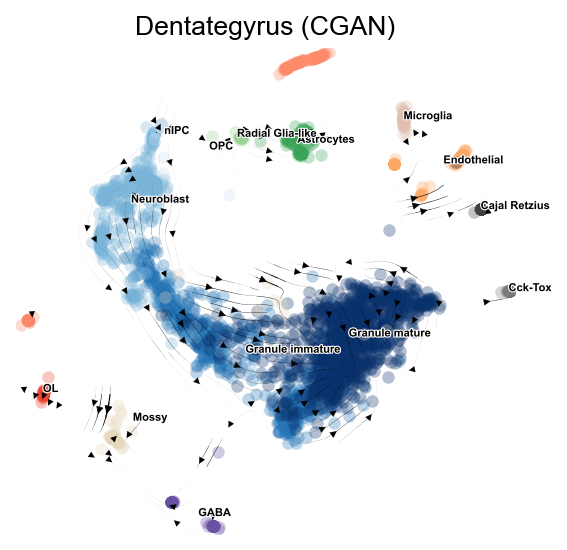

In [84]:
import matplotlib.pyplot as plt
fig,ax=v1.plot_stream(basis='X_mde',clusters='celltype',
               density_grid=0.8, scatter_size=30, scatter_alpha=0.3, linewidth=0.5)
plt.title('Dentategyrus (CGAN)',fontsize=12)
plt.savefig('figures/via_dg_cgan.png',dpi=300,bbox_inches='tight')

<AxesSubplot: title={'center': 'PAGA LTNN-graph'}>

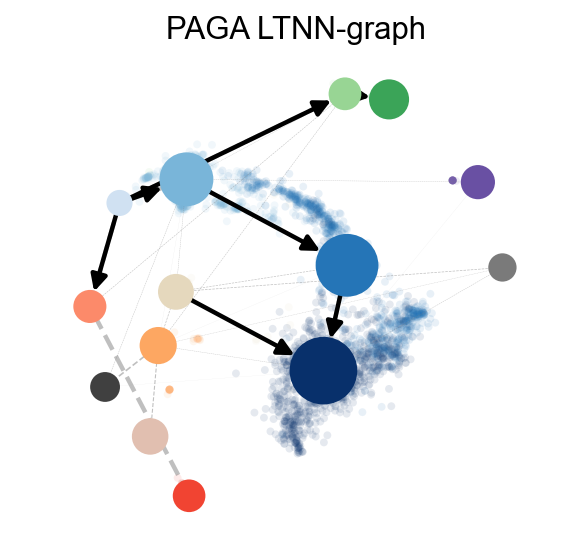

In [85]:
ov.utils.plot_paga(adata2,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)

In [86]:
v1.get_pseudotime(adata1)
sc.pp.neighbors(adata1,n_neighbors= 15,use_rep='scaled|original|X_pca')
ov.utils.cal_paga(adata1,use_time_prior='pt_via',vkey='paga',
                 groups='celltype')

...the pseudotime of VIA added to AnnData obs named `pt_via`
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running PAGA using priors: ['pt_via']
    finished
added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


In [87]:
after_transitions=pd.DataFrame(adata1.uns['paga']['transitions_confidence'].toarray(),
            index=adata1.obs['celltype'].cat.categories,
            columns=adata1.obs['celltype'].cat.categories)

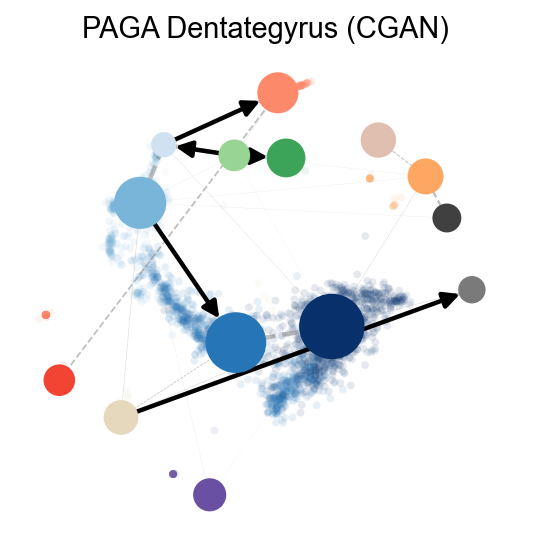

In [88]:
ov.utils.plot_paga(adata1,basis='mde', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False,legend_loc=False)
plt.title('PAGA Dentategyrus (CGAN)',fontsize=13)
plt.savefig('figures/paga_dg_cgan.png',dpi=300,bbox_inches='tight')
plt.savefig('pdf/paga_dg_cgan.pdf',dpi=300,bbox_inches='tight')

(0.0, 1.0)

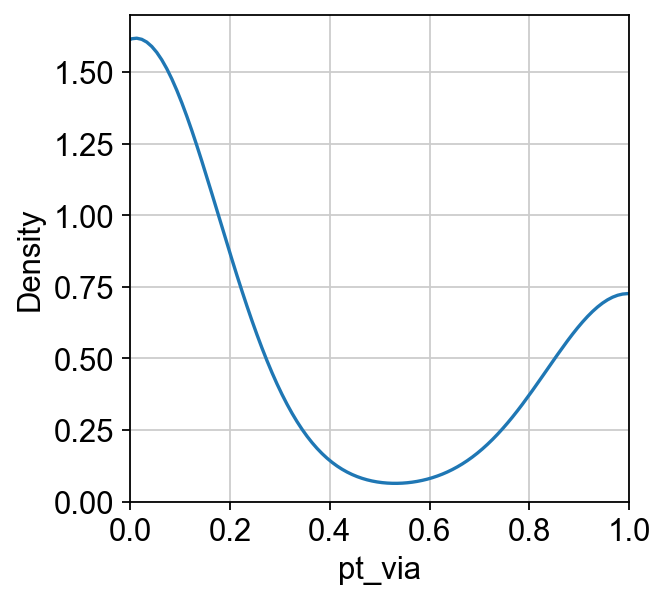

In [89]:
import seaborn as sns
sns.kdeplot(adata1.obs.loc[adata1.obs['celltype']=='OPC'],x='pt_via')
plt.xlim(0,1)

In [90]:
np.var(adata1.obs.loc[adata1.obs['celltype']=='OPC','pt_via'])

0.2050766394636122

(0.0, 1.0)

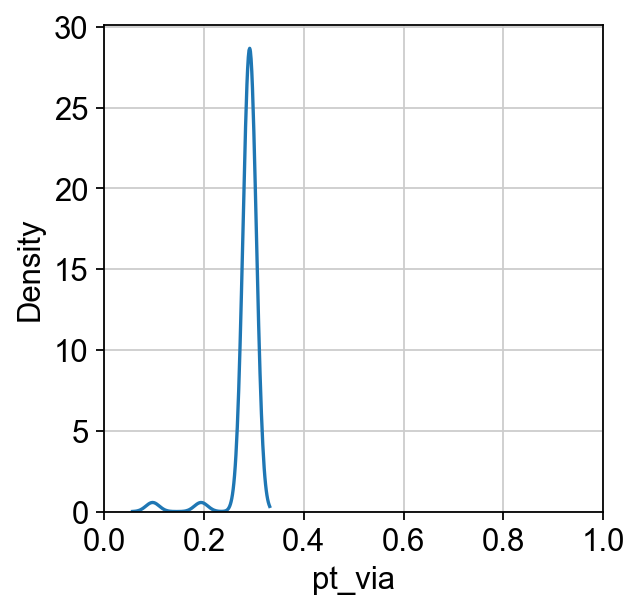

In [91]:
import seaborn as sns
sns.kdeplot(adata2.obs.loc[adata2.obs['celltype']=='OPC'],x='pt_via')
plt.xlim(0,1)

In [93]:
np.var(adata2.obs.loc[adata2.obs['celltype']=='OPC','pt_via'])

0.0008610680040077388

In [104]:
res_dict={}

#Cor:exp
# 计算对角线均值
diagonal_mean = np.trace(cor_pd.values) / len(cor_pd)
# 计算非对角线均值
non_diagonal_mean = (np.sum(cor_pd.values) - np.trace(cor_pd.values)) / (len(cor_pd)**2 - len(cor_pd))

res_dict['Cor_mean']=diagonal_mean
res_dict['non_Cor_mean']=non_diagonal_mean

#Cos:gene
# 计算对角线均值
diagonal_mean = np.trace(plot_data.values) / len(plot_data)

# 计算非对角线均值
non_diagonal_mean = (np.sum(plot_data.values) - np.trace(plot_data.values)) / (len(plot_data)**2 - len(plot_data))

res_dict['Cos_mean']=diagonal_mean
res_dict['non_Cos_mean']=non_diagonal_mean

#raw:trans
res_dict['Trans_raw']=raw_transitions.loc['OPC'].max()
res_dict['Trans_after']=after_transitions.loc['OPC'].max()


#Variance
res_dict['Var_raw']=np.var(adata2.obs.loc[adata2.obs['celltype']=='OPC','pt_via'])
res_dict['Var_after']=np.var(adata1.obs.loc[adata1.obs['celltype']=='OPC','pt_via'])


In [105]:
res_dict

{'Cor_mean': 0.8853872742612411,
 'non_Cor_mean': 0.5940097187211791,
 'Cos_mean': 0.1824074221901813,
 'non_Cos_mean': 0.013552926489814078,
 'Trans_raw': 0.012605069833265089,
 'Trans_after': 0.01236477520165905,
 'Var_raw': 0.0008610680040077388,
 'Var_after': 0.2050766394636122}

In [106]:
import pickle
with open('result/metric_cgan_dg.pkl','wb') as f:
    pickle.dump(res_dict,f)

In [107]:
with open('result/metric_cgan_dg.pkl','rb') as f:
    res_dict=pickle.load(f)
res_dict

{'Cor_mean': 0.8853872742612411,
 'non_Cor_mean': 0.5940097187211791,
 'Cos_mean': 0.1824074221901813,
 'non_Cos_mean': 0.013552926489814078,
 'Trans_raw': 0.012605069833265089,
 'Trans_after': 0.01236477520165905,
 'Var_raw': 0.0008610680040077388,
 'Var_after': 0.2050766394636122}